In [1]:
!jt -l

Available Themes: 
   chesterish
   grade3
   gruvboxd
   gruvboxl
   monokai
   oceans16
   onedork
   solarizedd
   solarizedl


In [2]:
# !jt -t monokai
!jt -r

Reset css and font defaults in:
/Users/mdonnelly/.jupyter/custom &
/Users/mdonnelly/Library/Jupyter/nbextensions


In [3]:
#!/usr/bin/env python
# coding: utf-8

import pandas as pd
import numpy as np
import os, time, stat, io, glob, pickle
from scipy.stats import gamma, norm
from scipy.integrate import odeint
import matplotlib.pyplot as plt

from covid_data_helper import *
from coronita_model_helper import *
%load_ext autoreload
%autoreload 2

In [4]:
# ## DATA INGESTION ##

# df_st_testing = get_covid19_tracking_data()

# df_census = get_census_pop()

# df_counties = get_complete_county_data()

# counties_geo = get_counties_geo()

# df_jhu_counties = get_jhu_counties()

# df_st_testing_fmt = df_st_testing.copy()
# df_st_testing_fmt = df_st_testing_fmt.rename(columns={'death':'deaths','positive':'cases'}).unstack('code')

# df_interventions = get_state_policy_events()

# df_goog_mob_us = get_goog_mvmt_us()
# df_goog_mob_state = get_goog_mvmt_state(df_goog_mob_us)
# df_goog_mob_us = df_goog_mob_us[df_goog_mob_us.state.isnull()].set_index('dt')

# #######################

In [5]:
list_of_files = glob.glob('./output/allstate_model_dicts_*.pkl') # * means all if need specific format then *.csv
latest_file = max(list_of_files, key=os.path.getctime)
print(latest_file)
with open(latest_file, 'rb') as handle:
    allstate_model_dicts = pickle.load(handle)
    

./output/allstate_model_dicts_20210103.pkl


In [6]:
# l_states_to_fore = df_census.state.unique()
l_states_to_fore = ['NY']

In [7]:
## MODEL PARAMETERS ##

covid_params = {}
covid_params['d_incub'] = 3.
covid_params['d_infect'] = 4.
covid_params['mort_rt'] = 0.01
covid_params['d_in_hosp'] = 11
covid_params['hosp_rt'] = 0.04
covid_params['d_to_hosp'] = 7.0
covid_params['d_in_hosp_mild'] = 11.0
covid_params['icu_rt'] = 13./41.
covid_params['d_in_icu'] = 13.0
covid_params['vent_rt'] = 0.4
covid_params['d_til_death'] =  17.0
covid_params['policy_trigger'] = True
covid_params['policy_trigger_once'] = True
days_to_forecast = 150

#######################

### RUN MODEL ###
df_fore_allstates = pd.DataFrame()

try:
    list_of_files = glob.glob('./output/df_fore_allstates_*.pkl') # * means all if need specific format then *.csv
    latest_file = max(list_of_files, key=os.path.getctime)
    print('last forecast: ', latest_file)
    df_prevfore_allstates = pd.read_pickle(latest_file)
except:
    if 'df_fore_allstates' in globals().keys():
        if df_fore_allstates.shape[0] > 0:
            df_prevfore_allstates = df_fore_allstates.copy()

last forecast:  ./output/df_fore_allstates_20210103.pkl


In [8]:
# allstate_model_dicts['ND']['df_all_cohorts'
#                           ].loc[:,:'2020-12-20'].sum(axis=1).unstack('metric').iloc[-270:-120].plot()
# # allstate_model_dicts['ND']['df_agg']


In [9]:
# state= 'ND'

# model_dict = make_model_dict_state(state, abbrev_us_state, df_census, df_st_testing_fmt,
#                                    covid_params, days_to_forecast,
#                                    df_mvmt=df_goog_mob_state
#                                  , df_interventions=df_interventions
#                                   )

# this_reg_df_rts = pd.DataFrame(model_dict['df_rts'].stack(), columns=[state])
# this_reg_df_wavg = pd.DataFrame(
#     model_dict['df_rts_conf'].sort_index().unstack('metric')['weighted_average'].stack(), columns=[state])

# # df_rts_allregs = pd.concat([df_rts_allregs, this_reg_df_rts], axis=1)
# # df_wavg_rt_conf_allregs = pd.concat([df_wavg_rt_conf_allregs, this_reg_df_wavg], axis=1)

# try:
#     first_guess = df_prevfore_allstates[state].first_valid_index()[0]
# except:
#     first_guess = pd.Timestamp('2020-02-17')

# model_dict = model_find_start(first_guess, model_dict)
# df_agg = model_dict['df_agg']
# df_all_cohorts = model_dict['df_all_cohorts']

# print('Peak Hospitalization Date: ', df_agg.hospitalized.idxmax().strftime("%d %b, %Y"))
# print('Peak Hospitalization #: {:.0f}'.format(df_agg.hospitalized.max()))
# print('Peak ICU #: {:.0f}'.format(df_agg.icu.max()))
# print('Peak Ventilator #: {:.0f}'.format(df_agg.vent.max()))

# model_dict['chart_title'] = r'No Change in Future $R_{t}$ Until 20% Hospital Capacity Trigger'

In [10]:
def ode_model(z, t, beta, sigma, gamma, mu):
    """
    Reference https://www.idmod.org/docs/hiv/model-seir.html
    """
    S, E, I, R, D = z
    N = S + E + I + R + D
    dSdt = -beta*S*I/N
    dEdt = beta*S*I/N - sigma*E
    dIdt = sigma*E - gamma*I - mu*I
    dRdt = gamma*I
    dDdt = mu*I
    return [dSdt, dEdt, dIdt, dRdt, dDdt]

def ode_solver(t, initial_conditions, covid_params):
    initE, initI, initR, initN, initD = initial_conditions
    beta, sigma, gamma, mu = params['beta'].value, params['sigma'].value, params['gamma'].value, params['mu'].value
    initS = initN - (initE + initI + initR + initD)
    res = odeint(ode_model, [initS, initE, initI, initR, initD], t, args=(beta, sigma, gamma, mu))
    return res



In [11]:
allstate_model_dicts['NY']['df_rts']['weighted_average'].dropna()

2020-02-21    3.611777
2020-02-22    3.485018
2020-02-23    3.307005
2020-02-24    3.103131
2020-02-25    2.883455
                ...   
2020-12-22    1.175735
2020-12-23    1.213852
2020-12-24    1.244719
2020-12-25    1.265182
2020-12-26    1.275025
Freq: D, Name: weighted_average, Length: 310, dtype: float64

In [12]:
model_dict = allstate_model_dicts['NY'].copy()


## Basic Non-Cohort Version

N           3.864574e-01
E           7.462370e+04
E_new       6.598440e+00
I_Mild      9.685556e+05
I_Sev       1.297316e+05
I_Fatal     4.324387e+04
H_Sev       5.118172e+05
H_Fatal     2.668150e+05
H_Admits    2.858052e+04
R           9.731612e+07
D           6.891959e+05
Name: 2021-05-20 23:00:00, dtype: float64


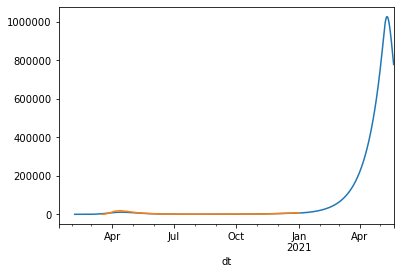

In [13]:
def noncohort_ode_model(z, t_, r_ts, covid_params):
    S, E, E_new, I_Mild, I_Sev, I_Fatal, H_Sev, H_Fatal, H_Admits, R, D = z
    N = S + E + I_Mild + I_Sev + I_Fatal + H_Sev + H_Fatal + R + D
    I = I_Mild + I_Sev + I_Fatal
    H = H_Sev + H_Fatal
    
    
    if int(t_) < r_ts.shape[0]:
        try:
            r_t = r_ts.iloc[int(t_)]
        except:
            print(int(t_))
    else:
        r_t = r_ts.iloc[-1]

    ## FLOWS ##
    
    _sigma = 1/covid_params['d_incub']
    _gamma = 1/covid_params['d_infect']
    _beta = r_t * _gamma
    _nu = 1/covid_params['d_to_hosp']
    _rho = 1/covid_params['d_in_hosp']
    _mu = 1/covid_params['d_til_death']
    
    p_fatal = covid_params['mort_rt']
    p_recov_sev = covid_params['hosp_rt'] - covid_params['mort_rt']
    p_recov_mild = 1 - covid_params['hosp_rt']

    dSdt = -min(_beta*I, S) #-_beta*S*I/N
    dEdt = min(_beta*I, S) - _sigma*E #_beta*S*I/N - _sigma*E
    E_new = min(_beta*I, S) - E_new
    
    dI_Milddt = p_recov_mild*_sigma*E - _gamma*I_Mild
    dI_Sevdt = p_recov_sev*_sigma*E - _nu*I_Sev
    dI_Fataldt = p_fatal*_sigma*E - _nu*I_Fatal
    
    dH_Sevdt = _nu*I_Sev - _rho*H_Sev
    dH_Fataldt = _nu*I_Fatal - _mu*H_Fatal
    H_Admits = _nu*I_Sev + _nu*I_Fatal - H_Admits
    
    dRdt = _gamma*I_Mild + _rho*H_Sev
    dDdt = _mu*H_Fatal
    return [dSdt, dEdt, E_new, dI_Milddt, dI_Sevdt, dI_Fataldt, dH_Sevdt, dH_Fataldt, H_Admits, dRdt, dDdt]

start_dt = '2020-02-05 11:00'
end_dt = '2021-05-21'
days = (pd.Timestamp(end_dt) - pd.Timestamp(start_dt)).total_seconds() / (24 * 60 * 60)
hrs_per_point = 6
granularity = hrs_per_point/24.
initN = 1e8
initE, E_new = 1e2, 1e2
initI_Mild, initI_Sev, initI_Fatal = 0, 0, 0
initH_Sev, initH_Fatal, initH_Admits = 0, 0, 0
initR = 0
initD = 0
initial_conditions = [initN, initE, E_new,
                      initI_Mild, initI_Sev, initI_Fatal, 
                      initH_Sev, initH_Fatal, initH_Admits, 
                      initR, initD]


r_ts = model_dict['df_rts']['weighted_average'].dropna().reindex(
    pd.date_range(start_dt,end_dt, freq=f'1D').normalize()).interpolate().fillna(method='ffill').fillna(method='bfill')
r_ts.index = (r_ts.index - pd.Timestamp(start_dt)).days

tspan = np.arange(0, days, granularity)
# ode_r_ts = r_ts.interpolate()
# ode_r_ts.index = tspan

# r_ts = model_dict['df_rts']['weighted_average'].dropna().reindex(
#     pd.date_range(start_dt,end_dt, freq=f'{hrs_per_point}H'))
# ode_r_ts = r_ts.interpolate()
# ode_r_ts.index = ode_r_ts.index.to_numpy().astype(int)
# tspan = ode_r_ts.index

sol = odeint(noncohort_ode_model, initial_conditions, tspan, args=(r_ts,covid_params,))

df_sol = pd.DataFrame(sol, 
                      columns=['N', 'E', 'E_new', 
                               'I_Mild', 'I_Sev', 'I_Fatal', 
                               'H_Sev', 'H_Fatal', 'H_Admits', 'R','D'], 
                      index=pd.date_range(start_dt, end_dt, freq=f'{hrs_per_point}H'))
# df_sol.plot(); plt.show()
# df_sol.R.diff().plot(); plt.show()
df_sol[['H_Sev','H_Fatal']].sum(axis=1).plot()
model_dict['df_hist']['hosp_concur'].plot()

print(df_sol.iloc[-1])



## Main Non-Cohort Version with Minimization

In [14]:
def noncohort_ode_model(z, t_, r_ts, params):
    S, E, E_new, I_Mild, I_Sev, I_Fatal, H_Sev, H_Fatal, H_Admits, R, D = z
    N = S + E + I_Mild + I_Sev + I_Fatal + H_Sev + H_Fatal + R + D
    I = I_Mild + I_Sev + I_Fatal
    H = H_Sev + H_Fatal
    
    try:
        r_t = r_ts.loc[int(t_)]
    except:
        print(int(t_))

    ## FLOWS ##
    
    _sigma = 1 / params['d_incub'].value
    _gamma = 1 / params['d_infect'].value
    _beta = r_t * _gamma
    _nu = 1 / params['d_to_hosp'].value
    _rho = 1 / params['d_in_hosp'].value
    _mu = 1 / params['d_til_death'].value
    
    p_fatal = params['mort_rt'].value
    p_recov_sev = params['hosp_rt'].value - params['mort_rt'].value
    p_recov_mild = 1 - params['hosp_rt'].value

    dSdt = -min(_beta*I, S)
    dEdt = min(_beta*I, S) - _sigma*E
    E_new = min(_beta*I, S) - E_new
    
    dI_Milddt = p_recov_mild*_sigma*E - _gamma*I_Mild
    dI_Sevdt = p_recov_sev*_sigma*E - _nu*I_Sev
    dI_Fataldt = p_fatal*_sigma*E - _nu*I_Fatal
    
    dH_Sevdt = _nu*I_Sev - _rho*H_Sev
    dH_Fataldt = _nu*I_Fatal - _mu*H_Fatal
    H_Admits = _nu*I_Sev + _nu*I_Fatal - H_Admits
    
    dRdt = _gamma*I_Mild + _rho*H_Sev
    dDdt = _mu*H_Fatal
    return [dSdt, dEdt, E_new, dI_Milddt, dI_Sevdt, dI_Fataldt, dH_Sevdt, dH_Fataldt, H_Admits, dRdt, dDdt]

def error(params, initial_conditions, tspan, r_ts_nodt, data):
    start_dt_fmt = pd.Timestamp('2020-01-01') + pd.Timedelta(days=params['start_dt'].value)
    print(start_dt_fmt)
    
    this_r_ts_nodt = r_ts_nodt.copy()
    this_r_ts_nodt.index = (this_r_ts_nodt.index - start_dt_fmt).days
    
    sol = odeint(noncohort_ode_model, initial_conditions, tspan, args=(this_r_ts_nodt, params,))
    
    df_sol = sol_array_to_df(sol, params, days, granularity, hrs_per_point)
    
#     return (df_sol[['H_Sev', 'H_Fatal']].sum(axis=1).resample('D').mean() - data).dropna().to_numpy()
    return (df_sol - data).dropna(axis=1, how='all').dropna().to_numpy()
#     return (df_sol[['H_Sev', 'H_Fatal']].sum(axis=1).resample('D').mean() - data).pow(2).mean()**.5

def sol_array_to_df(sol, params, days, granularity, hrs_per_point):
    df_sol = pd.DataFrame(sol, 
                      columns=['N', 'E', 'E_new', 
                               'I_Mild', 'I_Sev', 'I_Fatal', 
                               'H_Sev', 'H_Fatal', 'H_Admits', 'R','D'], 
                      index=pd.date_range(
                          (pd.Timestamp('2020-01-01') + pd.Timedelta(days=params['start_dt'].value)), 
                           periods=days/granularity, freq=f'{hrs_per_point}H')
                     )
    agg_dict = {
        'E': 'mean',
        'E_new': 'sum',
        'I_Mild': 'mean',
        'I_Sev': 'mean',
        'I_Fatal': 'mean',
        'H_Sev': 'mean',
        'H_Fatal': 'mean',
        'H_Admits': 'sum', 
        'R': 'max',
        'D': 'max'} 
    df_sol_daily = df_sol.resample('D').agg(agg_dict)
    df_sol_daily['deaths_tot'] = df_sol_daily['D']
    df_sol_daily['deaths_daily'] = df_sol_daily['D'].diff()
    df_sol_daily['hosp_admits'] = df_sol_daily['H_Admits']
    df_sol_daily['hosp_concur'] = df_sol_daily[['H_Sev','H_Fatal']].sum(axis=1)
    return df_sol_daily

2020-01-26 00:00:00


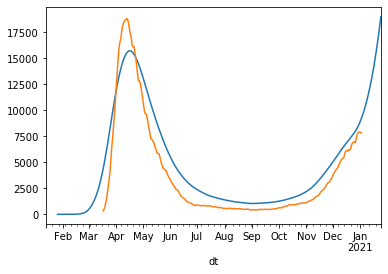

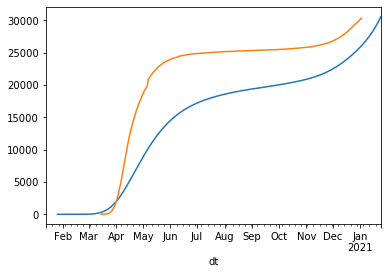

E               2.064817e+05
E_new           7.416718e+04
I_Mild          2.284524e+05
I_Sev           9.421366e+03
I_Fatal         4.193320e+03
H_Sev           1.033746e+04
H_Fatal         8.663464e+03
H_Admits        1.869593e+03
R               3.599766e+06
D               3.057128e+04
deaths_tot      3.057128e+04
deaths_daily    2.836871e+02
hosp_admits     1.869593e+03
hosp_concur     1.900093e+04
Name: 2021-01-24 00:00:00, dtype: float64


In [60]:
from lmfit import minimize, Parameters, Parameter, report_fit

params = Parameters()
params.add('d_incub', value=model_dict['covid_params']['d_incub'], vary=False, min=1, max=5)
params.add('d_infect', value=model_dict['covid_params']['d_infect'], vary=False, min=2, max=7)
params.add('d_to_hosp', value=model_dict['covid_params']['d_to_hosp'], vary=False, min=2, max=10)
params.add('d_in_hosp', value=model_dict['covid_params']['d_in_hosp'], vary=False, min=2, max=20)
params.add('d_til_death', value=model_dict['covid_params']['d_til_death'], vary=False, min=8, max=45)
params.add('mort_rt', value=model_dict['covid_params']['mort_rt'], vary=True, min=0.001, max=0.04)
params.add('hosp_rt', value=model_dict['covid_params']['hosp_rt'], vary=True, min=0.01, max=0.15)
params.add('start_dt', value=25, vary=False, min=0, max=100)


r_ts = model_dict['df_rts']['weighted_average'].dropna()
r_ts_nodt = r_ts.reindex(pd.date_range('2020-01-01', periods=365*2, freq='1D'))
r_ts_nodt = r_ts_nodt.interpolate().fillna(method='ffill').fillna(method='bfill')

days = 365.*1
hrs_per_point = 24
granularity = hrs_per_point/24.
initN = 1e8
initE, E_new = 1e1, 1e1
initI_Mild, initI_Sev, initI_Fatal = 0, 0, 0
initH_Sev, initH_Fatal, initH_Admits = 0, 0, 0
initR = 0
initD = 0
initial_conditions = [initN, initE, E_new,
                      initI_Mild, initI_Sev, initI_Fatal, 
                      initH_Sev, initH_Fatal, initH_Admits, 
                      initR, initD]

tspan = np.arange(0, days, granularity)

start_dt_fmt = pd.Timestamp('2020-01-01') + pd.Timedelta(days=params['start_dt'].value)
print(start_dt_fmt)

this_r_ts_nodt = r_ts_nodt.copy()
this_r_ts_nodt.index = (this_r_ts_nodt.index - start_dt_fmt).days

sol = odeint(noncohort_ode_model, initial_conditions, tspan, args=(this_r_ts_nodt, params,))

df_sol = sol_array_to_df(sol, params, days, granularity, hrs_per_point)

df_sol['hosp_concur'].plot()
model_dict['df_hist']['hosp_concur'].plot()
plt.show()

df_sol['deaths_tot'].plot()
model_dict['df_hist']['deaths_tot'].plot()
plt.show()

print(df_sol.iloc[-1])


In [57]:
(df_sol - model_dict['df_hist']).dropna(axis=1, how='all').dropna(how='all').columns

Index(['deaths_daily', 'deaths_tot', 'hosp_admits', 'hosp_concur'], dtype='object')

In [61]:
# %%time
data = model_dict['df_hist'][['deaths_tot', 'hosp_concur', 'deaths_daily']].dropna()

r_ts = model_dict['df_rts']['weighted_average'].dropna()
r_ts_nodt = r_ts.reindex(pd.date_range('2020-01-01', periods=365*2, freq='1D'))
r_ts_nodt = r_ts_nodt.interpolate().fillna(method='ffill').fillna(method='bfill')

result = minimize(error, 
                  params, 
                  args=(initial_conditions, tspan, r_ts_nodt, data)
                  , method='brute'
                  , max_nfev=50
                 )
display(result)


2020-01-26 00:00:00
2020-01-26 00:00:00
2020-01-26 00:00:00
2020-01-26 00:00:00
2020-01-26 00:00:00
2020-01-26 00:00:00
2020-01-26 00:00:00
2020-01-26 00:00:00
2020-01-26 00:00:00
2020-01-26 00:00:00
2020-01-26 00:00:00
2020-01-26 00:00:00
2020-01-26 00:00:00
2020-01-26 00:00:00
2020-01-26 00:00:00
2020-01-26 00:00:00
2020-01-26 00:00:00
2020-01-26 00:00:00
2020-01-26 00:00:00
2020-01-26 00:00:00
2020-01-26 00:00:00
2020-01-26 00:00:00
2020-01-26 00:00:00
2020-01-26 00:00:00
2020-01-26 00:00:00
2020-01-26 00:00:00
2020-01-26 00:00:00
2020-01-26 00:00:00
2020-01-26 00:00:00
2020-01-26 00:00:00
2020-01-26 00:00:00
2020-01-26 00:00:00
2020-01-26 00:00:00
2020-01-26 00:00:00
2020-01-26 00:00:00
2020-01-26 00:00:00
2020-01-26 00:00:00
2020-01-26 00:00:00
2020-01-26 00:00:00
2020-01-26 00:00:00
2020-01-26 00:00:00
2020-01-26 00:00:00
2020-01-26 00:00:00
2020-01-26 00:00:00
2020-01-26 00:00:00
2020-01-26 00:00:00
2020-01-26 00:00:00
2020-01-26 00:00:00
2020-01-26 00:00:00
2020-01-26 00:00:00


In [ ]:
# TO do tomorrow
# ADD A PARAMETER FOR A SLOPE OVER TIME ON THE MORTALITY AND HOSP RATES.
# Think of it this way, 
# you want maybe a 4% hosp rate in March and a 3.5% in Dec
# maybe a 1.5% mort rate in march and a 0.5% in Dec. Different slopes, but you need a change to make it work.


2020-01-26 00:00:00


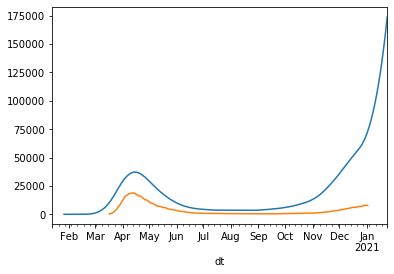

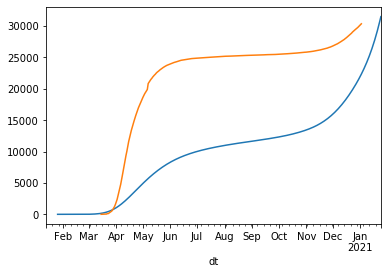

E               1.049987e+06
E_new           3.798788e+05
I_Mild          1.088626e+06
I_Sev           1.467384e+05
I_Fatal         9.533572e+03
H_Sev           1.557228e+05
H_Fatal         1.840072e+04
H_Admits        2.137220e+04
R               1.018692e+07
D               3.147779e+04
deaths_tot      3.147779e+04
deaths_daily    6.010776e+02
hosp_admits     2.137220e+04
hosp_concur     1.741235e+05
Name: 2021-01-24 00:00:00, dtype: float64


In [62]:
start_dt_fmt = pd.Timestamp('2020-01-01') + pd.Timedelta(days=result.params['start_dt'].value)
print(start_dt_fmt)

this_r_ts_nodt = r_ts_nodt.copy()
this_r_ts_nodt.index = (this_r_ts_nodt.index - start_dt_fmt).days

sol = odeint(noncohort_ode_model, initial_conditions, tspan, args=(this_r_ts_nodt, result.params,))

df_sol = sol_array_to_df(sol, params, days, granularity, hrs_per_point)

df_sol['hosp_concur'].plot()
model_dict['df_hist']['hosp_concur'].plot()
plt.show()

df_sol['deaths_tot'].plot()
model_dict['df_hist']['deaths_tot'].plot()
plt.show()

print(df_sol.iloc[-1])

## SciPy Model

In [20]:
# from scipy.optimize import minimize, rosen, rosen_der


## Basic Daily Cohort Model

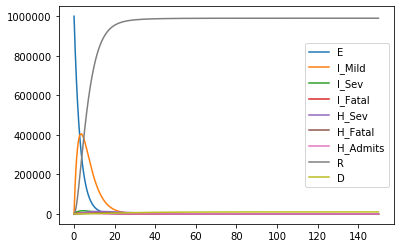

E           1.962320e-16
I_Mild      2.008308e-10
I_Sev       2.608757e-05
I_Fatal     8.695856e-06
H_Sev       1.361368e-01
H_Fatal     3.046646e+00
H_Admits    5.796183e-06
R           9.899999e+05
D           9.996953e+03
Name: 149.95833333333331, dtype: float64


In [21]:
# where mu = 1 / d_til_death
# mu*x / (mu*x + gamma) = mort_rt
# mux = mort * mux + mort*gamma
# mux - mort* mux = mort*gamma
# mux * (1 - mort) = mort* gamma
# x * (mu - mort*mu) = mort * gamma
# x = (mort_rt * gamma) / (mu - mort_rt * mu)
# x = (mort_rt * gamma) / mu*(1 - mort_rt)
# x = d_til_death * mort_rt * gamma / (1-mort_rt)

def cohort_ode_model(z, t_, covid_params):
    E, I_Mild, I_Sev, I_Fatal, H_Sev, H_Fatal, H_Admits, R, D = z
    ## FLOWS ##
    
    _sigma = 1/covid_params['d_incub']
    _gamma = 1/covid_params['d_infect']
    _nu = 1/covid_params['d_to_hosp']
    _rho = 1/covid_params['d_in_hosp']
    _mu = 1/covid_params['d_til_death']
    
    p_fatal = covid_params['mort_rt']
    p_recov_sev = covid_params['hosp_rt'] - covid_params['mort_rt']
    p_recov_mild = 1 - covid_params['hosp_rt']

    dEdt = -_sigma*E
    
    dI_Milddt = p_recov_mild*_sigma*E - _gamma*I_Mild
    dI_Sevdt = p_recov_sev*_sigma*E - _nu*I_Sev
    dI_Fataldt = p_fatal*_sigma*E - _nu*I_Fatal
    
    dH_Sevdt = _nu*I_Sev - _rho*H_Sev
    dH_Fataldt = _nu*I_Fatal - _mu*H_Fatal
    H_Admits = _nu*I_Sev + _nu*I_Fatal - H_Admits
    
    dRdt = _gamma*I_Mild + _rho*H_Sev
    dDdt = _mu*H_Fatal
    return [dEdt, dI_Milddt, dI_Sevdt, dI_Fataldt, dH_Sevdt, dH_Fataldt, H_Admits, dRdt, dDdt]

days = 150
hrs_per_point = 1.
granularity = hrs_per_point/24.
# initN = 1e8
initE = 1e6
initI_Mild, initI_Sev, initI_Fatal = 0, 0, 0
initH_Sev, initH_Fatal, initH_Admits = 0, 0, 0
initR = 0
initD = 0
initial_conditions = [initE, initI_Mild, initI_Sev, initI_Fatal, initH_Sev, initH_Fatal, initH_Admits, initR, initD]

tspan = np.arange(0, days, granularity)
sol = odeint(cohort_ode_model, initial_conditions, tspan, args=(covid_params,))

df_sol = pd.DataFrame(sol, 
                      columns=['E', 'I_Mild', 'I_Sev', 'I_Fatal', 'H_Sev', 'H_Fatal', 'H_Admits', 'R','D'], 
                      index=tspan)
df_sol.plot(); plt.show()
df_sol.R.diff().plot; plt.show()

print(df_sol.iloc[-1])


In [22]:
%%timeit
sol = odeint(cohort_ode_model, initial_conditions, tspan, args=(covid_params,))

5.5 ms ± 295 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


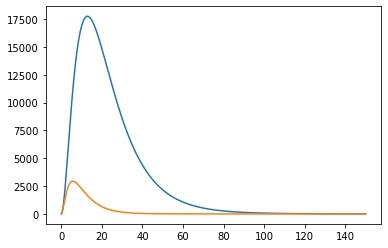

In [23]:
# df_sol[['H_Sev', 'H_Fatal']].div(df_sol[['H_Sev', 'H_Fatal']].sum(axis=1), axis=0).plot()
ax = df_sol[['H_Sev', 'H_Fatal']].sum(axis=1).plot()
df_sol.H_Admits.plot(ax=ax)


In [24]:
days = 365
# initN = 1e8
initE = 1
initI = 1
initH = 0
initR = 0
initD = 0
initial_conditions = [initE, initI, initH, initR, initD]

tspan = np.arange(0, days, 1)
sol = ode_solver(tspan, initial_conditions, covid_params)
E, I, H, R, D, d_hosp_admits = sol[:, 0], sol[:, 1], sol[:, 2], sol[:, 3], sol[:, 4]

KeyError: 'beta'

In [ ]:
# function that returns dy/dt
def model(y,t):
    if t >5:
#         k = 0.3
#         dydt = -k * y
        dydt = gamma.pdf(t, 5)
    else:
        dydt = 0
    return dydt

# initial condition
y0 = 5

# time points
t = np.linspace(0,20, 100)

# solve ODE
y = odeint(model,y0,t)

plt.plot(t,y)

In [ ]:
%%timeit
y = odeint(model,y0,t)

In [ ]:
%%timeit 
y = [5]
for t_ in t:

    dydt = model(y[-1], t_)

    y_ = y[-1] + dydt

    y = y + [y_]

# y[-1]

In [ ]:
plt.plot(t,y[1:])

In [ ]:
allstate_model_dicts = {}
df_rts_allregs = pd.DataFrame()
df_wavg_rt_conf_allregs = pd.DataFrame()

for state in l_states_to_fore:
    print(state)
    
    model_dict = make_model_dict_state(state, abbrev_us_state, df_census, df_st_testing_fmt,
                                       covid_params, days_to_forecast,
                                       df_mvmt=df_goog_mob_state
                                     , df_interventions=df_interventions
                                      )
    
    this_reg_df_rts = pd.DataFrame(model_dict['df_rts'].stack(), columns=[state])
    this_reg_df_wavg = pd.DataFrame(
        model_dict['df_rts_conf'].sort_index().unstack('metric')['weighted_average'].stack(), columns=[state])

    df_rts_allregs = pd.concat([df_rts_allregs, this_reg_df_rts], axis=1)
    df_wavg_rt_conf_allregs = pd.concat([df_wavg_rt_conf_allregs, this_reg_df_wavg], axis=1)

    try:
        first_guess = df_prevfore_allstates[state].first_valid_index()[0]
    except:
        first_guess = pd.Timestamp('2020-02-17')

    model_dict = model_find_start(first_guess, model_dict)
    df_agg = model_dict['df_agg']
    df_all_cohorts = model_dict['df_all_cohorts']

    print('Peak Hospitalization Date: ', df_agg.hospitalized.idxmax().strftime("%d %b, %Y"))
    print('Peak Hospitalization #: {:.0f}'.format(df_agg.hospitalized.max()))
    print('Peak ICU #: {:.0f}'.format(df_agg.icu.max()))
    print('Peak Ventilator #: {:.0f}'.format(df_agg.vent.max()))

    model_dict['chart_title'] = r'No Change in Future $R_{t}$ Until 20% Hospital Capacity Trigger'

    allstate_model_dicts[state] = model_dict
    df_fore_allstates = pd.concat([df_fore_allstates,pd.DataFrame(df_agg.stack(), columns=[state])], axis=1)

#######################

### Add US Country Level Entries Before Saving ###
df_fore_us = df_fore_allstates.sum(axis=1, skipna=True).unstack('metric').dropna(how='all')
tot_pop = df_fore_us[['susceptible', 'deaths', 'exposed', 'hospitalized', 'infectious', 'recovered']].sum(axis=1)
max_tot_pop = tot_pop.max()
df_fore_us.loc[tot_pop<max_tot_pop, 'susceptible'] = df_fore_us['susceptible'] + (max_tot_pop - tot_pop)
df_fore_allstates = pd.concat([df_fore_allstates,pd.DataFrame(df_fore_us.stack(), columns=['US'])], axis=1)

model_dict = make_model_dict_us(df_census, df_st_testing_fmt, covid_params, d_to_forecast = 75,
                               df_mvmt=df_goog_mob_us, df_interventions=df_interventions)
model_dict['df_agg'] = df_fore_us
model_dict['chart_title'] = r'No Change in Future $R_{t}$ Until 20% Hospital Capacity Trigger'
allstate_model_dicts['US'] = model_dict

this_reg_df_wavg = pd.DataFrame(
    model_dict['df_rts_conf'].sort_index().unstack('metric')['weighted_average'].stack(), columns=['US'])
df_wavg_rt_conf_allregs = pd.concat([df_wavg_rt_conf_allregs, this_reg_df_wavg], axis=1)
###################################################

### Save Output ###
# df_rts_allregs.index.names = ['dt','metric']

# df_wavg_rt_conf_allregs.unstack('metric').to_csv(
#     './output/df_wavg_rt_conf_allregs_{}.csv'.format(pd.Timestamp.today().strftime("%Y%m%d")),
#     encoding='utf-8')
# df_wavg_rt_conf_allregs.to_pickle('./output/df_wavg_rt_conf_allregs_{}.pkl'.format(
#     pd.Timestamp.today().strftime("%Y%m%d")))

# df_fore_allstates.unstack('metric').to_csv(
#     './output/df_fore_allstates_{}.csv'.format(pd.Timestamp.today().strftime("%Y%m%d")),
#     encoding='utf-8')
# df_fore_allstates.unstack('metric').to_csv(
#     '../COVIDoutlook/download/df_fore_allstates_{}.csv'.format(pd.Timestamp.today().strftime("%Y%m%d")),
#     encoding='utf-8')
# df_fore_allstates.to_pickle('./output/df_fore_allstates_{}.pkl'.format(pd.Timestamp.today().strftime("%Y%m%d")))

# asmd_filename = './output/allstate_model_dicts_{}.pkl'.format(pd.Timestamp.today().strftime("%Y%m%d"))

# df_interventions.to_csv('../COVIDoutlook/download/df_interventions.csv', encoding='utf-8')

# with open(asmd_filename, 'wb') as handle:
#     pickle.dump(allstate_model_dicts, handle, protocol=pickle.HIGHEST_PROTOCOL)

# with open('filename.pickle', 'rb') as handle:
#     b = pickle.load(handle)

# os.system('say -v "Victoria" "Your forecasts are ready."')

######################

# os.system('python web_gen_covidoutlook.py &') # 'python web_gen_covidoutlook.py 2>&1 | tee -a web_gen_covidoutlook.log &'
# os.system('python web_gen_personal.py &')

In [ ]:
model_dict = make_model_dict_state('NY',abbrev_us_state,df_census,
    df_st_testing_fmt,
    covid_params,
    d_to_forecast=75,
    df_mvmt=df_goog_mob_state)
ax = ch_rt_confid(model_dict)

In [ ]:
from coronita_chart_helper import *
from coronita_web_helper import *
from coronita_bokeh_helper import *

### Settings and Functions for Personal Website ###
plt.style.use('ggplot')

def footnote_str_maker():
    footnote_str = 'www.COVIDoutlook.info | twtr: @COVIDoutlook\nChart created on {}'.format(
        pd.Timestamp.today().strftime("%d %b, %Y at %I:%M %p"))
    return footnote_str


def add_plotly_footnote(fig):
    fig.update_layout(
                  annotations=[
                      dict(x = 0, y = -0.06,
                           xref='paper', yref='paper', font_size=10, showarrow=False,
                           xanchor='left', yanchor='auto', xshift=0, yshift=0,
                            text='<a href="http://{0}">{0}</a> | twtr: <a href="https://twitter.com/COVIDoutlook">@COVIDoutlook</a> | '.format(
                           'www.COVIDoutlook.info')
                          ),
                      dict(x = 0, y = -0.09,
                           xref='paper', yref='paper', font_size=10, showarrow=False,
                           xanchor='left', yanchor='auto', xshift=0, yshift=0,
                           text='Chart created on {}'.format(pd.Timestamp.today().strftime("%d %b %Y"))
                          )
                  ]
                 )
    return fig
d_chart_fns = {'ch_rt_confid': ch_rt_confid,
 'ch_positivetests': ch_positivetests,
 'ch_totaltests': ch_totaltests,
 'ch_postestshare': ch_postestshare,
 'ch_detection_rt': ch_detection_rt,
 'ch_googmvmt': ch_googmvmt,
 'ch_exposed_infectious': ch_exposed_infectious,
 'ch_hosp': ch_hosp,
 'ch_population_share': ch_population_share,
 'ch_cumul_infections': ch_cumul_infections,
 'ch_daily_exposures': ch_daily_exposures,
 'ch_hosp_admits': ch_hosp_admits,
 'ch_daily_deaths': ch_daily_deaths}


In [ ]:
for state_code in l_states_to_fore:
    print(state_code)
    model_dict = allstate_model_dicts[state_code]
    model_dict['footnote_str'] = footnote_str_maker()

    # fig = ch_statemap2(df_counties.query('dt == dt.max() and state == "{}"'.format(state_code)),
    #                    model_dict['region_name'],
    #                    df_counties.query('dt == dt.max()').cases_per100k.quantile(.9),
    #                    counties_geo
    #                   )
    fig = ch_statemap_casechange(model_dict, df_counties, counties_geo)
    fig = add_plotly_footnote(fig)
    # fig.write_html('../COVIDoutlook/forecasts/plotly/{}_casepercap_cnty_map.html'.format(
    #     model_dict['region_code']), include_plotlyjs='cdn')

    for ch_name, ch_fn in d_chart_fns.items():
        try:
            ax = ch_fn(model_dict)
            filename = '../COVIDoutlook/assets/images/covid19/{}_{}.png'.format(
                model_dict['region_code'], ch_name)
    #         plt.savefig(filename, bbox_inches='tight')
            plt.show()
            plt.close()
            # os.system('optipng {} &'.format(filename))
        except:
            print('Couldn\'t create {} {} chart.'.format(model_dict['region_code'], ch_name))

    statetab_output_cols = ['Riskiest State Rank', 'Population',
                   'Model Est\'d Active Infections', 'Current Reproduction Rate (Rt)',
                   'Total Cases', '14-Day Avg Daily Cases',
                   'Positivity Rate',
                   'Total Deaths', '14-Day Avg Daily Deaths',
                   'Hospitalized', '14-Day Avg Daily Hosp Admits'
                   ]
    # if state_code == 'US':
    #     statetab = df_tab_us[statetab_output_cols[1:]].replace('nan', 'Not Available')
    # else:
    #     statetab = df_tab.loc[df_tab.state==state_code, statetab_output_cols].replace('nan', 'Not Available')

    # statetab_html = statetab.to_html(index=False, border=0, justify='center', escape=False)
    # statetab_html = statetab_html.replace(
    #     'class="dataframe"', 'class="w3-table w3-striped w3-bordered w3-hoverable w3-medium"')
    # statetab_html = statetab_html.replace(
    #     '<tr style="text-align: center;">', '<tr style="text-align: center;" class="w3-light-grey">')

    # l_content = [statetab_html, '### How Fast is COVID-19 Currently Spreading?']

    # for thischart in l_charts:
    #     if thischart == 'ch_statemap':
    #         # l_content.append('{{% include_relative plotly/{}_casepercap_cnty_map.html %}}'.format(state_code))
    #         l_content.append(state_plotly_html.format(state_code))
    #     else:
    #         l_content.append("<img src='/assets/images/covid19/{}_{}.png'>".format(
    #             state_code, thischart))

    #     if thischart in dict_ch_defs.keys():
    #         l_content.append(dict_ch_defs[thischart]+'\n- - - -')

    # l_content.insert(15, '### Model and Forecast Results')

    # final_md = state_md_template.format(model_dict['region_name'], state_code, '\n'.join(l_content))

    # if state_code == 'US':
    #     filename = "../COVIDoutlook/forecasts/index.md".format(state_code)
    # else:
    #     filename = "../COVIDoutlook/forecasts/{}.md".format(state_code)

    # with open(filename, "w") as file:
    #     file.write(final_md)